# EDA & Preprocessing

Este código no es completamente reproducible, ya que se usa un conjunto de datos muy extenso para la imputación de valores faltantes, así como otros componentes de código disponibles en el proyecto WindFormer.

En este primer notebook, se analizan los datos y se comparan con datos de reanalisis (datos geenerados por un modelo numérico a partir de observaciones reales). También se realiza un primer preprocesamiento.

In [ ]:
#!sudo apt install libgeos-dev

In [109]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import h5py
import warnings
from mpl_toolkits.basemap import Basemap
from utils.config_loader import load_config
from processing.preprocessing_real import preprocess_real_data

config = load_config("./config/params_real.yaml")

Cargamos los datos

In [3]:
years = config['real_data']['years']
image_size = config['model']['image_size_2d']

# Set paths
real_data_path = os.path.join(config['global']['path'], config['global']['real_data_path'])
reanalysis_data_path = os.path.join(config['global']['path'], config['global']['processed_data_path'], 'data.hdf5')
constants_path = os.path.join(config['global']['path'], config['global']['constants_path'])
output_file_path = os.path.join(config['global']['path'], config['global']['processed_data_path'], 'real_data.hdf5')

# Get climatologies
climatologies_path = os.path.join(constants_path, 'climatologies.pickle')
with open(climatologies_path, 'rb') as file:
    climatologies = pickle.load(file)['surface_climatologies']

# Get index of lon and lat for each data point
longitudes = np.load(os.path.join(constants_path, 'longitude.npy'))
latitudes = np.load(os.path.join(constants_path, 'latitude.npy'))

pena_lat = config['real_data']['locations']['pena']['latitude']
pena_lon = config['real_data']['locations']['pena']['longitude']
jara_lat = config['real_data']['locations']['jara']['latitude']
jara_lon = config['real_data']['locations']['jara']['longitude']
minon_lat = config['real_data']['locations']['minon']['latitude']
minon_lon = config['real_data']['locations']['minon']['longitude']

jara_idx = (np.where(latitudes == jara_lat)[0][0], np.where(longitudes == jara_lon)[0][0])
pena_idx = (np.where(latitudes == pena_lat)[0][0], np.where(longitudes == pena_lon)[0][0])
minon_idx = (np.where(latitudes == minon_lat)[0][0], np.where(longitudes == minon_lon)[0][0])

# Get index for wind variables
var_names = config['preprocessing']['surface_var_names'][1:]
u10_idx = var_names.index('u10')
v10_idx = var_names.index('v10')

In [8]:
# Datos raw
jara = pd.read_csv('./data/real/jara.csv', names=['d', 'm', 'y', 'h', 'vel', 'dir'], header=None)
mnon = pd.read_csv('./data/real/minon.csv', names=['d', 'm', 'y', 'h', 'vel', 'dir'], header=None)
pena = pd.read_csv('./data/real/pena.csv', names=['d', 'm', 'y', 'h', 'vel', 'dir'], header=None)

# Coordenadas de los puntos
coordinates = np.array([
    [40.2665477, -6.6262572],  # Peñaparda
    [37.1101227, -4.9182429],  # Jara
    [42.4651620, -3.7918493]   # Miñon
])

# Determinando los extremos ajustados a 0.25 grados
min_lat = np.floor(coordinates[:, 0].min() / 0.25) * 0.25
max_lat = np.ceil(coordinates[:, 0].max() / 0.25) * 0.25
min_lon = np.floor(coordinates[:, 1].min() / 0.25) * 0.25
max_lon = np.ceil(coordinates[:, 1].max() / 0.25) * 0.25

# Coordenadas del cuadrado
square_coordinates = {
    "min_lat": min_lat,
    "max_lat": max_lat,
    "min_lon": min_lon,
    "max_lon": max_lon
}

Ubicamos los datos en la Península Ibérica

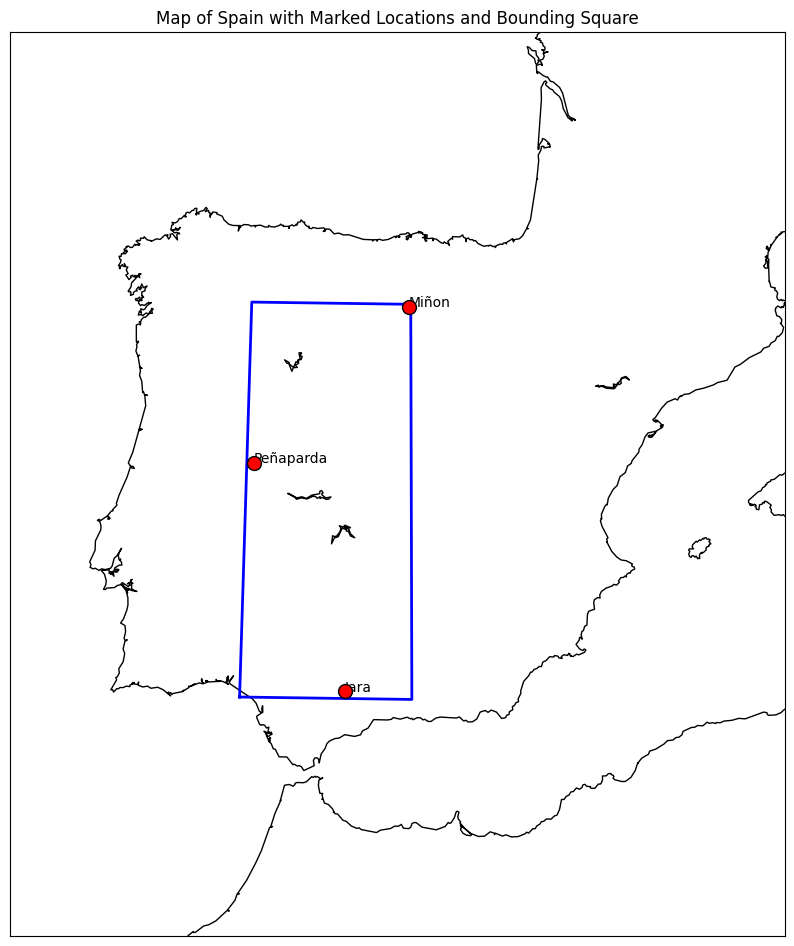

In [9]:
square_lats = [min_lat, min_lat, max_lat, max_lat, min_lat]
square_lons = [min_lon, max_lon, max_lon, min_lon, min_lon]


fig, ax = plt.subplots(figsize=(10, 15))
m = Basemap(projection='lcc', resolution='i',
            lat_0=40, lon_0=-4,
            width=1.2E6, height=1.4E6, ax=ax)

m.drawcoastlines()

# Plotear los puntos originales
x, y = m([-6.6262572, -4.9182429, -3.7918493], [40.2665477, 37.1101227, 42.4651620])
m.scatter(x, y, 100, color='red', marker='o', edgecolors='k', zorder=5)

x_square, y_square = m(square_lons, square_lats)
m.plot(x_square, y_square, marker=None, color='blue', linewidth=2)

for label, xpt, ypt in zip(["Peñaparda", "Jara", "Miñon"], x, y):
    plt.text(xpt, ypt, label)

plt.title('Map of Spain with Marked Locations and Bounding Square')
plt.show()


Procesamos los datos para seguir el formato: timestamp, velocity, direction

In [10]:
def process_dataframe(df):
    df['date'] = df['d'].astype(str) + '-' + df['m'].astype(str) + '-' + df['y'].astype(str) + ' ' + df['h'].astype(str)
    df['timestamp'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H')
    
    df = df[['timestamp', 'vel', 'dir']]
    return df

jara = process_dataframe(jara)minon
mnon = process_dataframe(mnon)
pena = process_dataframe(pena)

Comprobamos que las series son estacionarias.

In [13]:
from statsmodels.tsa.stattools import adfuller

# Run test
adf_result = adfuller(jara['vel'], autolag='AIC', maxlag=24, regression='ct', regresults=True)

# Parse test statistic and p value
print(f'ADF Test Statistic {adf_result[0]:.2f}')
print(f'P Value {adf_result[1]:.2f}')
if adf_result[1] > 0.05:
    print('Time series is not stationary. Time-dependent structure such as seasonality exists.')
else:
    print('Time series is stationary, p value < 0.05.')

ADF Test Statistic -13.18
P Value 0.00
Time series is stationary, p value < 0.05.


Calculamos los valores faltantes de cada serie. Se puede observar que existe un elevado porcentaje de datos faltantes, sobre todo en la serie de Peñaparda.

In [14]:
# Función para calcular el conteo y el porcentaje de -99 en la columna 'vel'
def calculate_minus_99_details(df):
    total_count = len(df) 
    minus_99_count = (df['vel'] == -99).sum()
    minus_99_percentage = (minus_99_count / total_count) * 100
    return minus_99_count, minus_99_percentage

count_jara, percentage_jara = calculate_minus_99_details(jara)
count_mnon, percentage_mnon = calculate_minus_99_details(mnon)
count_pena, percentage_pena = calculate_minus_99_details(pena)

# Imprimir resultados
print("Jara: valores -99 =", count_jara, ", porcentaje =", round(percentage_jara, 2), "%")
print("Miñon: valores -99 =", count_mnon, ", porcentaje =", round(percentage_mnon, 2), "%")
print("Peñaparda: valores -99 =", count_pena, ", porcentaje =", round(percentage_pena, 2), "%")

Jara: valores -99 = 6623 , porcentaje = 6.67 %
Miñon: valores -99 = 2664 , porcentaje = 2.82 %
Peñaparda: valores -99 = 15105 , porcentaje = 9.99 %


Como puede verse en las series de datos, a veces, los datos faltantes se prolongan durante periodos de tiempo largos

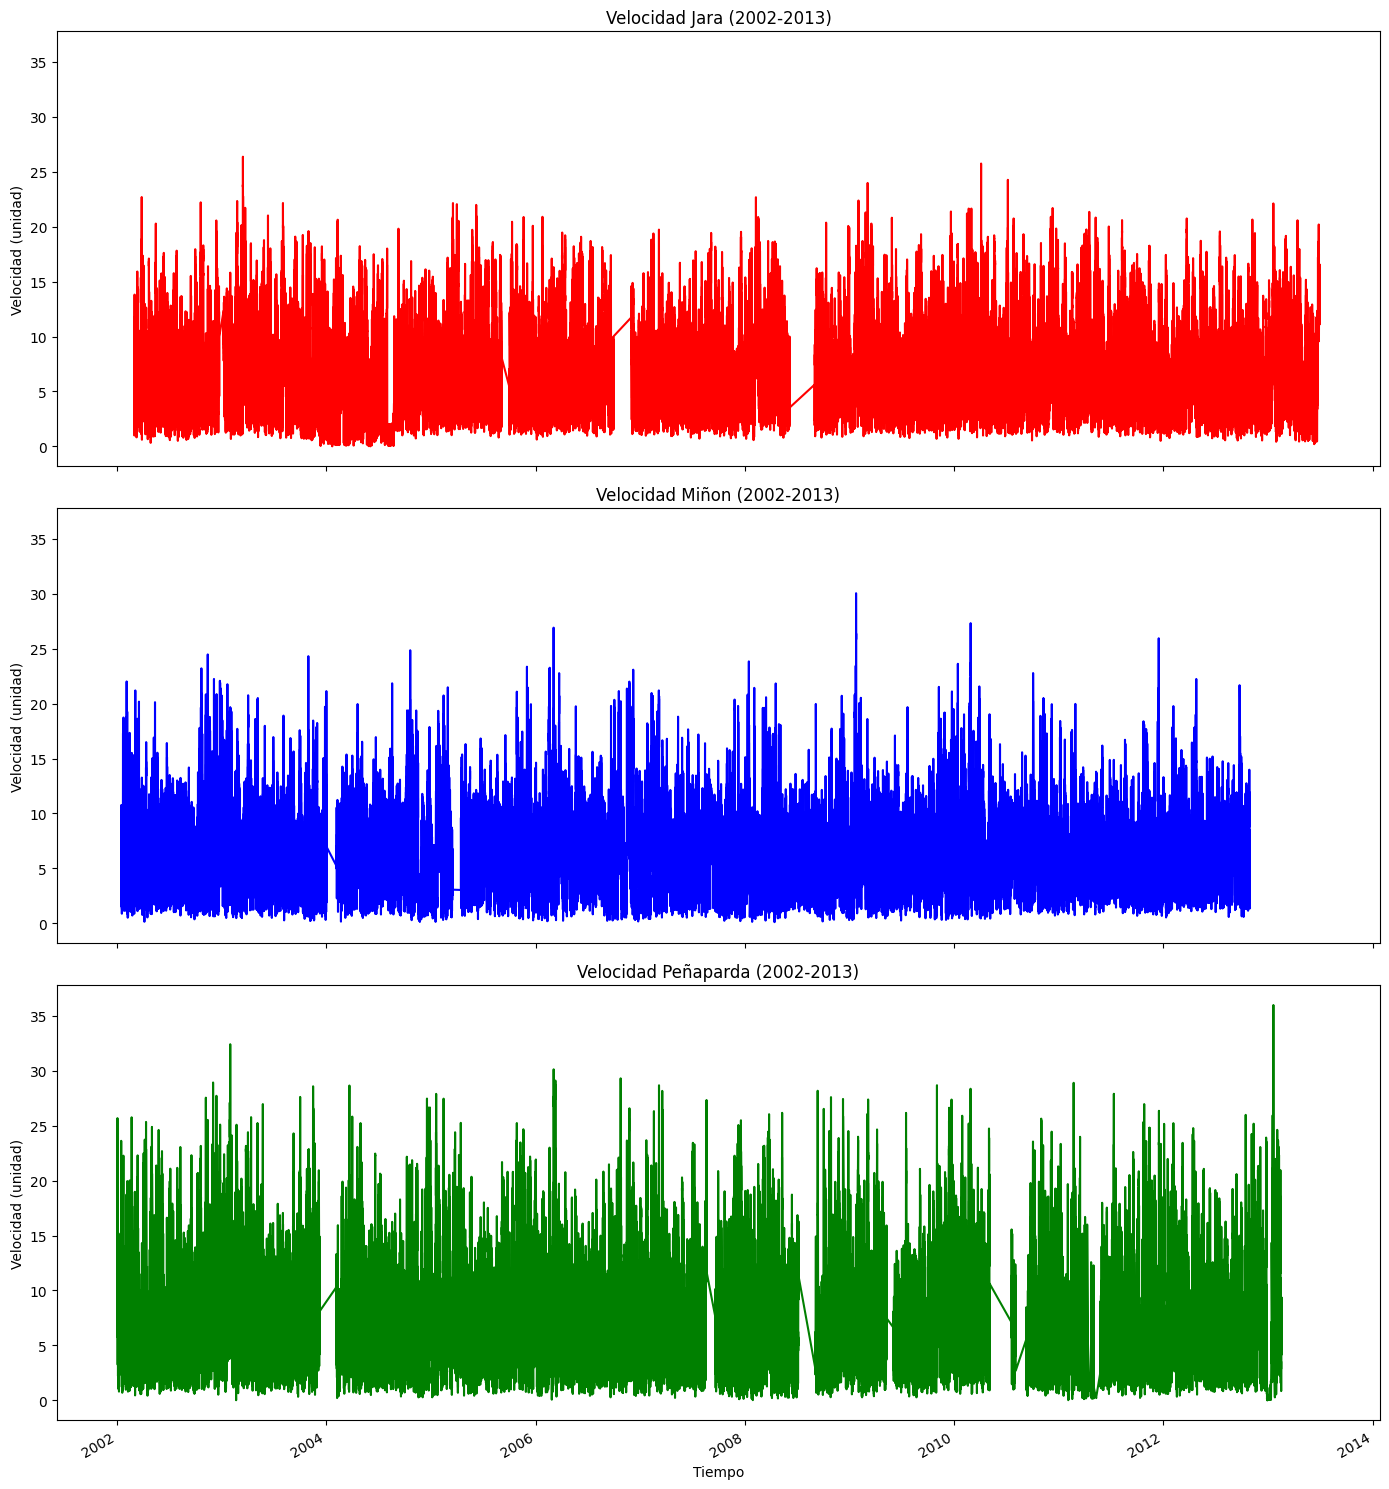

In [15]:
jara.loc[jara['vel'] == -99, 'vel'] = np.nan
mnon.loc[mnon['vel'] == -99, 'vel'] = np.nan
pena.loc[pena['vel'] == -99, 'vel'] = np.nan

# Filter the DataFrames by date and velocity values greater than -1
jara_filtered = jara[(jara['timestamp'].dt.year >= 2002) & (jara['timestamp'].dt.year <= 2013) & (jara['vel'] > -1)]
mnon_filtered = mnon[(mnon['timestamp'].dt.year >= 2002) & (mnon['timestamp'].dt.year <= 2013) & (mnon['vel'] > -1)]
pena_filtered = pena[(pena['timestamp'].dt.year >= 2002) & (pena['timestamp'].dt.year <= 2013) & (pena['vel'] > -1)]

# Configure the subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 15), sharex=True, sharey=True)

# Plot the filtered velocities in parallel subplots
axs[0].plot(jara_filtered['timestamp'], jara_filtered['vel'], color='red')
axs[0].set_title('Velocidad Jara (2002-2013)')
axs[0].set_ylabel('Velocidad (unidad)')

axs[1].plot(mnon_filtered['timestamp'], mnon_filtered['vel'], color='blue')
axs[1].set_title('Velocidad Miñon (2002-2013)')
axs[1].set_ylabel('Velocidad (unidad)')

axs[2].plot(pena_filtered['timestamp'], pena_filtered['vel'], color='green')
axs[2].set_title('Velocidad Peñaparda (2002-2013)')
axs[2].set_ylabel('Velocidad (unidad)')
axs[2].set_xlabel('Tiempo')

plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

Transformamos los datos en componentes u y v del viento

In [22]:
def calculate_wind_components(df):
    dir_rad = np.radians(df['dir'])
    
    df['U'] = -df['vel'] * np.sin(dir_rad)
    df['V'] = -df['vel'] * np.cos(dir_rad)
    return df

jara = calculate_wind_components(jara)
minon = calculate_wind_components(mnon)
pena = calculate_wind_components(pena)


En esta función se realizan varios procesos de preprocesamiento.
1. Calculo de climatologías diarias anuales (media por cada día de ambos componentes del viento sobre todos los años) (se calcula sobre el conjunto de entrenamiento solo)
2. Se restan las climatologías a los valores reales, obteniendo las anomalías (cómo difiere el viento sobre lo que suele ocurrir otros años en esa fecha)
3. Estandarización de los datos.
4. Imputación con datos de reanalisis (procesados de igual forma: extracción de anomalías y estandarización)

In [2]:
preprocess_real_data(config)

Se cargan los nuevos datos procesados junto a los de reanalisis para poder compararlos

In [85]:
# Set paths
real_data_path = os.path.join(config['global']['path'], config['global']['real_data_path'])
reanalysis_data_path = os.path.join(config['global']['path'], config['global']['processed_data_path'], 'data.hdf5')
constants_path = os.path.join(config['global']['path'], config['global']['constants_path'])

# Get climatologies
climatologies_path = os.path.join(constants_path, 'climatologies.pickle')
with open(climatologies_path, 'rb') as file:
    climatologies = pickle.load(file)["surface_climatologies"]

# Get index of lon and lat for each data point
longitudes = np.load(os.path.join(constants_path, 'longitude.npy'))
latitudes = np.load(os.path.join(constants_path, 'latitude.npy'))

pena_lat = config["real_data"]["locations"]["pena"]["latitude"]
pena_lon = config["real_data"]["locations"]["pena"]["longitude"]

jara_lat = config["real_data"]["locations"]["jara"]["latitude"]
jara_lon = config["real_data"]["locations"]["jara"]["longitude"]

minon_lat = config["real_data"]["locations"]["minon"]["latitude"]
minon_lon = config["real_data"]["locations"]["minon"]["longitude"]

pena_lat_idx = np.where(latitudes == pena_lat)[0][0]
pena_lon_idx = np.where(longitudes == pena_lon)[0][0]

jara_lat_idx = np.where(latitudes == jara_lat)[0][0]
jara_lon_idx = np.where(longitudes == jara_lon)[0][0]

minon_lat_idx = np.where(latitudes == minon_lat)[0][0]
minon_lon_idx = np.where(longitudes == minon_lon)[0][0]

var_names = config["preprocessing"]["surface_var_names"][1:]
u10_idx = var_names.index("u10")
v10_idx = var_names.index("v10")

In [90]:
data_path = os.path.join(config['global']['path'], config['global']['processed_data_path'])

pena_rea_list = []
jara_rea_list = []
minon_rea_list = []

pena_obs_list = []
jara_obs_list = []
minon_obs_list = []

with h5py.File(data_path + '/data.hdf5', 'r') as file:
    for year in range(2003, 2012): 
        year_str = str(year)
        if year_str in file.keys():
            pena_rea_data = file[year_str]['surface']['data'][:, pena_lat_idx, pena_lon_idx, u10_idx:v10_idx+1]
            jara_rea_data = file[year_str]['surface']['data'][:, jara_lat_idx, jara_lon_idx, u10_idx:v10_idx+1]
            minon_rea_data = file[year_str]['surface']['data'][:, minon_lat_idx, minon_lon_idx, u10_idx:v10_idx+1]

            pena_rea_list.append(pena_rea_data)
            jara_rea_list.append(jara_rea_data)
            minon_rea_list.append(minon_rea_data)

with h5py.File(data_path + '/real_data.hdf5', 'r') as file:
    for year in range(2003, 2012): 
        year_str = str(year)
        if year_str in file.keys():
            pena_obs_data = file[year_str]['surface']['data'][:, pena_lat_idx, pena_lon_idx, u10_idx:v10_idx+1]
            jara_obs_data = file[year_str]['surface']['data'][:, jara_lat_idx, jara_lon_idx, u10_idx:v10_idx+1]
            minon_obs_data = file[year_str]['surface']['data'][:, minon_lat_idx, minon_lon_idx, u10_idx:v10_idx+1]

            pena_obs_list.append(pena_obs_data)
            jara_obs_list.append(jara_obs_data)
            minon_obs_list.append(minon_obs_data)

pena_rea = np.concatenate(pena_rea_list, axis=0)
jara_rea = np.concatenate(jara_rea_list, axis=0)
minon_rea = np.concatenate(minon_rea_list, axis=0)

pena_obs = np.concatenate(pena_obs_list, axis=0)
jara_obs = np.concatenate(jara_obs_list, axis=0)
minon_obs = np.concatenate(minon_obs_list, axis=0)

date_range = pd.date_range(start='2003-01-01', end='2011-12-31 23:00:00', freq='h')

# Crear DataFrames de los arrays de NumPy para 2008
jara_rea_df = pd.DataFrame(jara_rea, columns=['U_rea', 'V_rea'], index=date_range)
minon_rea_df = pd.DataFrame(minon_rea, columns=['U_rea', 'V_rea'], index=date_range)
pena_rea_df = pd.DataFrame(pena_rea, columns=['U_rea', 'V_rea'], index=date_range)

jara_obs_df = pd.DataFrame(jara_obs, columns=['U_obs', 'V_obs'], index=date_range)
minon_obs_df = pd.DataFrame(minon_obs, columns=['U_obs', 'V_obs'], index=date_range)
pena_obs_df = pd.DataFrame(pena_obs, columns=['U_obs', 'V_obs'], index=date_range)


Comparamos ambos conjuntos de datos durante un año. Se puede observar que en 2 de las 3 localizaciones coinciden bastante exceptuando algunos extremos, que son dificiles de captar en el reanalisis.

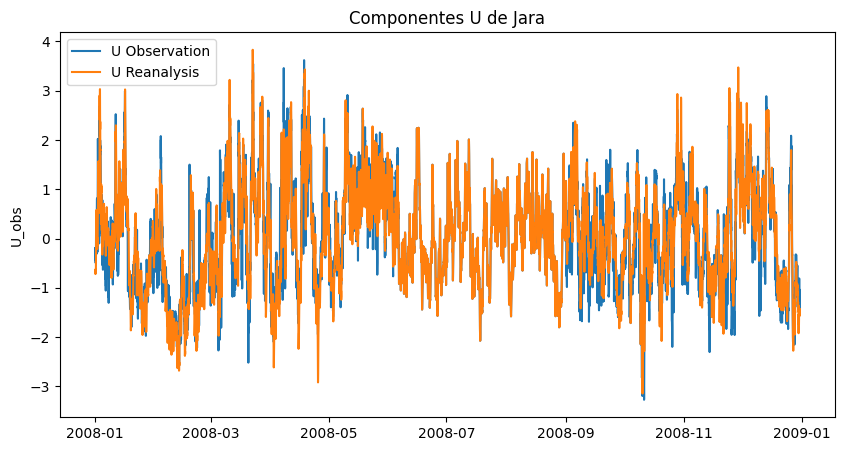

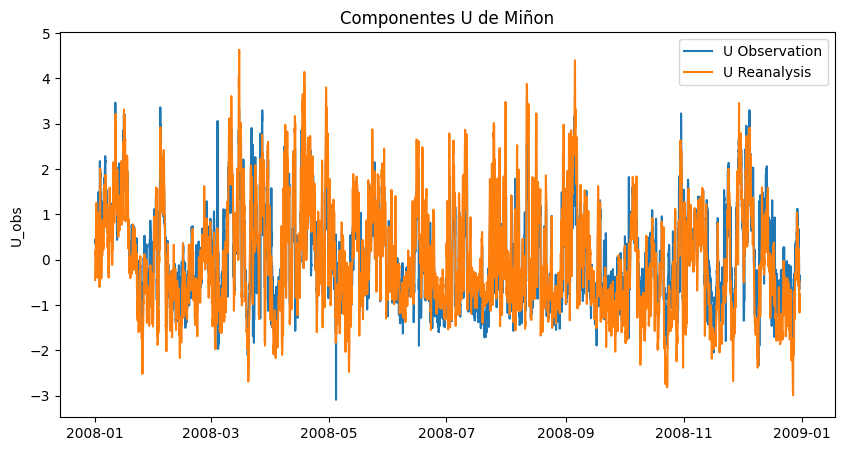

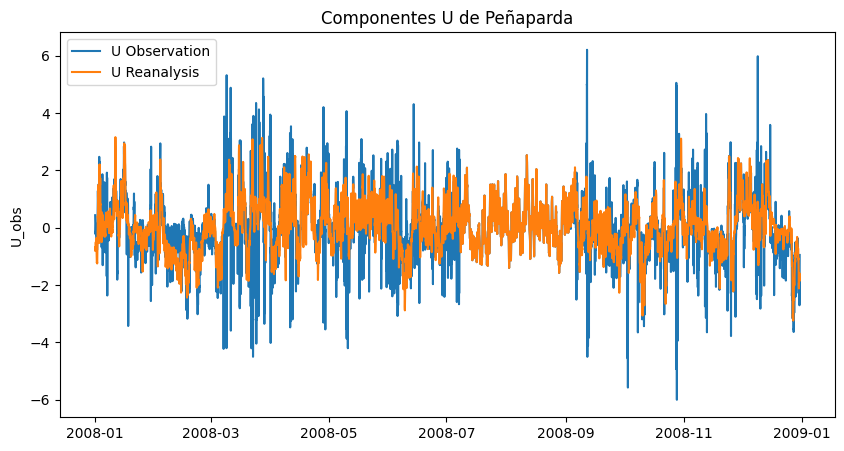

In [110]:
merged_jara = pd.merge(jara_rea_df, jara_obs_df, left_index=True, right_index=True, how='inner')
merged_minon = pd.merge(minon_rea_df, minon_obs_df, left_index=True, right_index=True, how='inner')
merged_pena = pd.merge(pena_rea_df, pena_obs_df, left_index=True, right_index=True, how='inner')

merged_jara = merged_jara[['U_rea', 'V_rea', 'U_obs', 'V_obs']]
merged_minon = merged_minon[['U_rea', 'V_rea', 'U_obs', 'V_obs']]
merged_pena = merged_pena[['U_rea', 'V_rea', 'U_obs', 'V_obs']]

merged_minon = merged_minon.loc[merged_minon.index >= '2008-01-01']
merged_minon = merged_minon.loc[merged_minon.index <= '2008-12-31']

merged_jara = merged_jara.loc[merged_jara.index >= '2008-01-01']
merged_jara = merged_jara.loc[merged_jara.index <= '2008-12-31']

merged_pena = merged_pena.loc[merged_pena.index >= '2008-01-01']
merged_pena = merged_pena.loc[merged_pena.index <= '2008-12-31']

# Crear gráficos de líneas para cada DataFrame
def plot_components(df, title):
    warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x=df.index, y="U_obs", label='U Observation')
    sns.lineplot(data=df, x=df.index, y="U_rea", label='U Reanalysis')
    plt.title(title)
    plt.legend()
    plt.show()

plot_components(merged_jara, 'Componentes U de Jara')
plot_components(merged_minon, 'Componentes U de Miñon')
plot_components(merged_pena, 'Componentes U de Peñaparda')


Si sacamos la correlación entre ambos conjuntos podemos corroborar lo observado previamente. Miñón y Jara presentan una alta correlación, mientras que Peñaparda una más baja.

In [98]:
# Calcular la correlación entre U y U_rea, y entre V y V_rea en merged_jara
correlation_u_jara = merged_jara['U_obs'].corr(merged_jara['U_rea'])
correlation_v_jara = merged_jara['V_obs'].corr(merged_jara['V_rea'])

# Calcular la correlación en merged_minon
correlation_u_minon = merged_minon['U_obs'].corr(merged_minon['U_rea'])
correlation_v_minon = merged_minon['V_obs'].corr(merged_minon['V_rea'])

# Calcular la correlación en merged_pena
correlation_u_pena = merged_pena['U_obs'].corr(merged_pena['U_rea'])
correlation_v_pena = merged_pena['V_obs'].corr(merged_pena['V_rea'])

# Imprimir los resultados
print("Correlación de U y U_rea en Jara:", correlation_u_jara)
print("Correlación de V y V_rea en Jara:", correlation_v_jara)
print("Correlación de U y U_rea en Miñon:", correlation_u_minon)
print("Correlación de V y V_rea en Miñon:", correlation_v_minon)
print("Correlación de U y U_rea en Peñaparda:", correlation_u_pena)
print("Correlación de V y V_rea en Peñaparda:", correlation_v_pena)

Correlación de U y U_rea en Jara: 0.9087341649376861
Correlación de V y V_rea en Jara: 0.8883811799914402
Correlación de U y U_rea en Miñon: 0.8661705544770096
Correlación de V y V_rea en Miñon: 0.8457280121666931
Correlación de U y U_rea en Peñaparda: 0.6586537367149468
Correlación de V y V_rea en Peñaparda: 0.744589935887409


Estos datos ya preprocesados e imputados son guardados en formato csv para su posterior uso en el siguiente notebook que si será completamente reproducible.